In [130]:
import pandas as pd                                                  # see below for install instruction
import numpy as np                                             # dense matrices
import matplotlib.pyplot as plt                                # plotting
from scipy.stats import multivariate_normal                    # multivariate Gaussian distribution
import copy                                                    # deep copies
import os

# image handling library
from PIL import Image
from io import BytesIO

%matplotlib inline

#### Log likelihood

In [3]:
def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters. """
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
        
    return ll

#### Compute responsibilities

In [5]:
def compute_responsibilities(data, weights, means, covariances):
    '''E-step: compute responsibilities, given the current parameters'''
    num_data = len(data)
    num_clusters = len(means)
    resp = np.zeros((num_data, num_clusters))
    
    # Update resp matrix so that resp[i,k] is the responsibility of cluster k for data point i.
    # Hint: To compute likelihood of seeing data point i given cluster k, use multivariate_normal.pdf.
    for i in range(num_data):
        for k in range(num_clusters):
            # YOUR CODE HERE
            resp[i, k] = weights[k] * multivariate_normal.pdf(data[i], mean=means[k], cov=covariances[k])
    
    # Add up responsibilities over each data point and normalize
    row_sums = resp.sum(axis=1)[:, np.newaxis]
    resp = resp / row_sums
    
    return resp

In [6]:
resp = compute_responsibilities(data=np.array([[1.,2.],[-1.,-2.]]), weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])

if resp.shape==(2,2) and np.allclose(resp, np.array([[0.10512733, 0.89487267], [0.46468164, 0.53531836]])):
    print('Checkpoint passed!')
else:
    print('Check your code again.')

Checkpoint passed!


#### Soft counts

In [7]:
def compute_soft_counts(resp):
    # Compute the total responsibility assigned to each cluster, which will be useful when 
    # implementing M-steps below. In the lectures this is called N^{soft}
    counts = np.sum(resp, axis=0)
    return counts

In [28]:
def compute_weights(counts):
    num_clusters = len(counts)
    
    return counts/sum(counts)

In [29]:
resp = compute_responsibilities(data=np.array([[1.,2.],[-1.,-2.],[0,0]]), weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
weights = compute_weights(counts)

print(counts)
print(weights)

if np.allclose(weights, [0.27904865942515705, 0.720951340574843]):
    print('Checkpoint passed!')
else:
    print('Check your code again.')

[ 0.83714598  2.16285402]
[ 0.27904866  0.72095134]
Checkpoint passed!


In [59]:
def compute_means(data, resp, counts):
    num_clusters = len(counts)
    num_data = len(data)
    means = [np.zeros(len(data[0]))] * num_clusters
    
    for k in range(num_clusters):
        # Update means for cluster k using the M-step update rule for the mean variables.
        # This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
        weighted_sum = 0
        for i in range(num_data):
            # YOUR CODE HERE
            weighted_sum += resp[i][k] * data[i]
        # YOUR CODE HERE
        means[k] = weighted_sum / counts[k]

    return means

In [60]:
data_tmp = np.array([[1.,2.],[-1.,-2.]])
resp = compute_responsibilities(data=data_tmp, weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
means = compute_means(data_tmp, resp, counts)
#print(counts)
if np.allclose(means, np.array([[-0.6310085, -1.262017], [0.25140299, 0.50280599]])):
    print('Checkpoint passed!')
else:
    print('Check your code again.')

Checkpoint passed!


#### Update covariance

In [65]:
def compute_covariances(data, resp, counts, means):
    num_clusters = len(counts)
    num_dim = len(data[0])
    num_data = len(data)
    covariances = [np.zeros((num_dim,num_dim))] * num_clusters
    
    for k in range(num_clusters):
        # Update covariances for cluster k using the M-step update rule for covariance variables.
        # This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
        weighted_sum = np.zeros((num_dim, num_dim))
        for i in range(num_data):
            # YOUR CODE HERE (Hint: Use np.outer on the data[i] and this cluster's mean)
            weighted_sum += resp[i][k] * np.outer(data[i]-means[k], data[i]-means[k])
        # YOUR CODE HERE
        covariances[k] = weighted_sum / counts[k]

    return covariances

In [66]:
data_tmp = np.array([[1.,2.],[-1.,-2.]])
resp = compute_responsibilities(data=data_tmp, weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
means = compute_means(data_tmp, resp, counts)
covariances = compute_covariances(data_tmp, resp, counts, means)
if np.allclose(covariances[0], np.array([[0.60182827, 1.20365655], [1.20365655, 2.4073131]])) and \
    np.allclose(covariances[1], np.array([[ 0.93679654, 1.87359307], [1.87359307, 3.74718614]])):
    print('Checkpoint passed!')
else:
    print('Check your code again.')

Checkpoint passed!


#### The EM algorithm

In [68]:
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    
    # Make copies of initial parameters, which we will update during each iteration
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    # Infer dimensions of dataset and the number of clusters
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    # Initialize some useful variables
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for it in range(maxiter):
        if it % 5 == 0:
            print("Iteration %s" % it)
        
        # E-step: compute responsibilities
        resp = compute_responsibilities(data, weights, means, covariances)

        # M-step
        # Compute the total responsibility assigned to each cluster, which will be useful when 
        # implementing M-steps below. In the lectures this is called N^{soft}
        counts = compute_soft_counts(resp)
        
                # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
        # YOUR CODE HERE
        weights = compute_weights(counts)
        
        # Update means for cluster k using the M-step update rule for the mean variables.
        # This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
        # YOUR CODE HERE
        means = compute_means(data, resp, counts)
        
        # Update covariances for cluster k using the M-step update rule for covariance variables.
        # This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
        # YOUR CODE HERE
        covariances = compute_covariances(data, resp, counts, means)
        
        # Compute the loglikelihood at this iteration
        # YOUR CODE HERE
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    if it % 5 != 0:
        print("Iteration %s" % it)
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

In [69]:
def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        #  Use np.random.choice and weights to pick a cluster id greater than or equal to 0 and less than num_clusters.
        k = np.random.choice(len(weights), 1, p=weights)[0]

        # Use np.random.multivariate_normal to create data from this cluster
        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data

In [70]:
# Model parameters
init_means = [
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [0, 5]  # mean of cluster 3
]
init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[.92, .38], [.38, .91]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
]
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

# Generate data
np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)

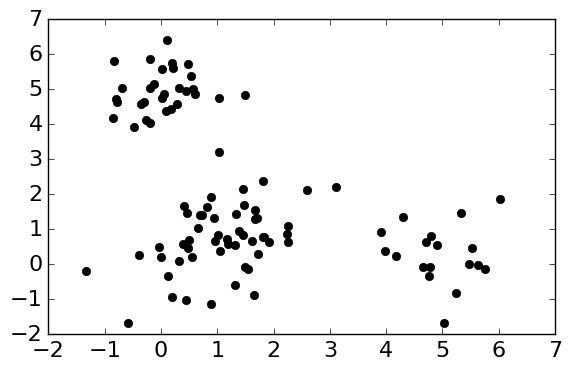

In [71]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [76]:
np.random.seed(4)

# Initialization of parameters
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] * 3
initial_weights = [1/3.] * 3

# Run EM 
results = EM(data, initial_means, initial_covs, initial_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


In [77]:
results.keys()

dict_keys(['resp', 'weights', 'loglik', 'covs', 'means'])

##### Quiz Question: What is the weight that EM assigns to the first component after running the above code block?



In [75]:
results['weights'][0]

0.30071023006098241

##### Quiz Question: Using the same set of results, obtain the mean that EM assigns the second component. What is the mean in the first dimension?

In [80]:
results['means'][1][0]

4.9423923529753555

##### Quiz Question: Using the same set of results, obtain the covariance that EM assigns the third component. What is the variance in the first dimension?

In [84]:
results['covs'][2][0][0]

0.67114991897184539

In [85]:
import matplotlib.mlab as mlab
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko') # data

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22
Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


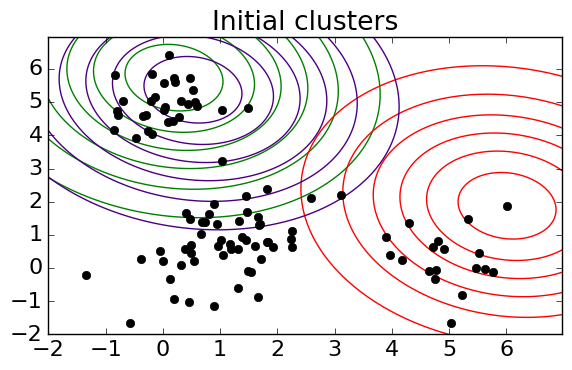

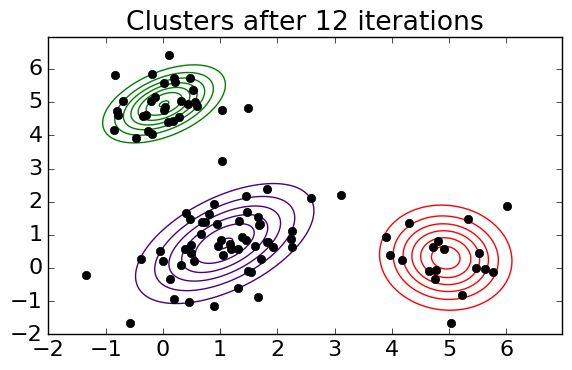

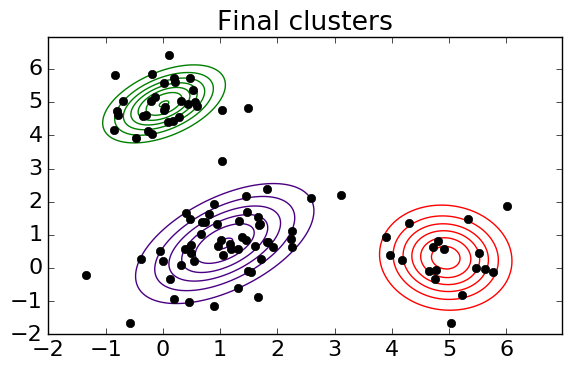

In [87]:
# Parameters after initialization
plot_contours(data, initial_means, initial_covs, 'Initial clusters')

# Parameters after 12 iterations
results = EM(data, initial_means, initial_covs, initial_weights)
plot_contours(data, results['means'], results['covs'], 'Clusters after 12 iterations')

# Parameters after running EM to convergence
results = EM(data, initial_means, initial_covs, initial_weights)
plot_contours(data, results['means'], results['covs'], 'Final clusters')

##### Quiz Question: Plot the loglikelihood that is observed at each iteration. Is the loglikelihood plot monotonically increasing, monotonically decreasing, or neither [multiple choice]? Complete the following code block to answer the question.

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


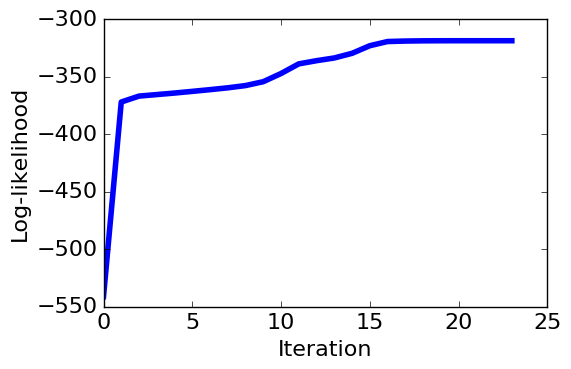

In [88]:
results = EM(data, initial_means, initial_covs, initial_weights)

# YOUR CODE HERE
loglikelihoods = results['loglik']

plt.plot(range(len(loglikelihoods)), loglikelihoods, linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

### Real data

In [146]:
folders = ['cloudy_sky', 'rivers', 'sunsets', 'trees_and_forest']

In [209]:
df = pd.DataFrame(columns=('red', 'green', 'blue', 'pic'))
df.loc[0] = [None, None, None, None]
for folder in folders:
    for image in os.listdir(os.path.join('images', folder)):
        pic = Image.open(os.path.join('images', folder, image))
        load_pic = pic.load()
        x = list(np.mean([load_pic[i, j] for j in range(pic.size[1]) for i in range(pic.size[0])], axis=0)/256) + [pic]
        df.loc[int(df.index.max() + 1)] = x
        
df = df.drop(df.index[[0]])
df = df.reset_index(drop=True)

In [249]:
df.ix[2, ['red', 'green', 'blue']].tolist()

[0.3457261367820324, 0.47025245168769653, 0.64784502435517255]

In [250]:
init_means = [df.ix[x, ['red', 'green', 'blue']].tolist() for x in np.random.choice(len(df), 4, replace=False)]



In [252]:
cov = np.diag([df['red'].var(), df['green'].var(), df['blue'].var()])



In [253]:
cov

array([[ 0.01595022,  0.        ,  0.        ],
       [ 0.        ,  0.01744421,  0.        ],
       [ 0.        ,  0.        ,  0.03378352]])

In [251]:
init_means

[[0.41486991552715019, 0.38668886865834323, 0.33661230739694809],
 [0.57778397817460314, 0.37822761656746035, 0.25216626364087302],
 [0.5201376700579089, 0.55156879040734574, 0.58423901254858801],
 [0.54679026066751579, 0.54946817905902956, 0.46030117758130001]]

In [255]:
np.array(df.ix[:, ['red', 'green', 'blue']])

array([[ 0.52853595,  0.53679828,  0.54671798],
       [ 0.41612734,  0.56794921,  0.76086133],
       [ 0.34572614,  0.47025245,  0.64784502],
       ..., 
       [ 0.37767138,  0.39254992,  0.37401613],
       [ 0.30445965,  0.37225797,  0.16177151],
       [ 0.4468084 ,  0.44889349,  0.37189645]])

In [256]:
np.random.seed(1)

# Initalize parameters
init_means = [df.ix[x, ['red', 'green', 'blue']].tolist() for x in np.random.choice(len(df), 4, replace=False)]
cov = np.diag([df['red'].var(), df['green'].var(), df['blue'].var()])
init_covariances = [cov, cov, cov, cov]
init_weights = [1/4., 1/4., 1/4., 1/4.]

# Convert rgb data to numpy arrays
img_data = np.array(df.ix[:, ['red', 'green', 'blue']]) 

# Run our EM algorithm on the image data using the above initializations. 
# This should converge in about 125 iterations
out = EM(img_data, init_means, init_covariances, init_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 25
Iteration 30
Iteration 35
Iteration 40
Iteration 45
Iteration 50
Iteration 55
Iteration 60
Iteration 65
Iteration 70
Iteration 75
Iteration 80
Iteration 84


#### Convergence: How did the log likelihood change across iterations? Did the algorithm achieve convergence?


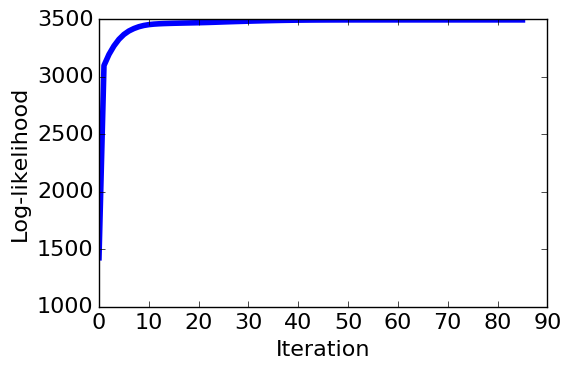

In [257]:
ll = out['loglik']
plt.plot(range(len(ll)),ll,linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

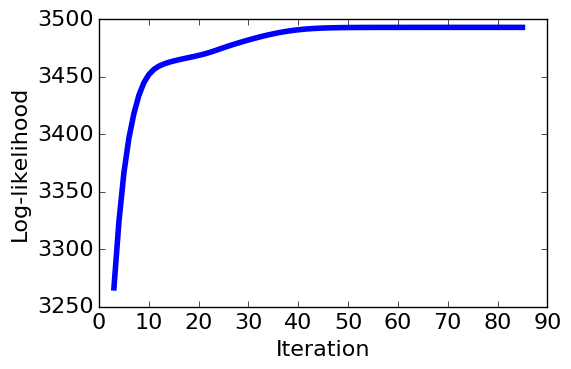

In [258]:
plt.figure()
plt.plot(range(3,len(ll)),ll[3:],linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

#### Uncertainty: How did cluster assignment and uncertainty evolve?

In [265]:
import colorsys
def plot_responsibilities_in_RB(img, resp, title):
    N, K = resp.shape
    
    HSV_tuples = [(x*1.0/K, 0.5, 0.9) for x in range(K)]
    RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
    
    R = img['red']
    B = img['blue']
    resp_by_img_int = [[resp[n][k] for k in range(K)] for n in range(N)]
    cols = [tuple(np.dot(resp_by_img_int[n], np.array(RGB_tuples))) for n in range(N)]

    plt.figure()
    for n in range(len(R)):
        plt.plot(R[n], B[n], 'o', c=cols[n])
    plt.title(title)
    plt.xlabel('R value')
    plt.ylabel('B value')
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

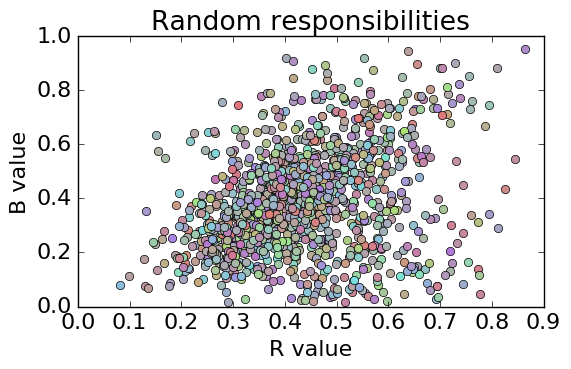

In [266]:
N, K = out['resp'].shape
random_resp = np.random.dirichlet(np.ones(K), N)
plot_responsibilities_in_RB(df, random_resp, 'Random responsibilities')

Iteration 0


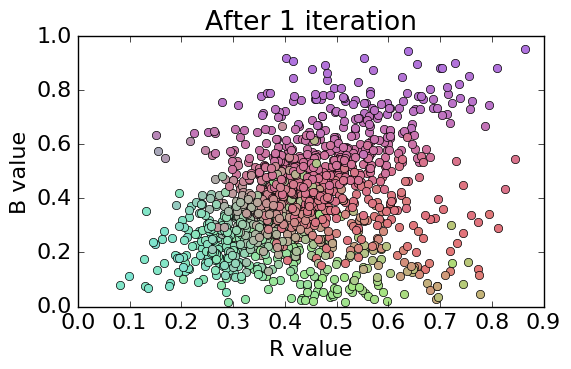

In [267]:
out = EM(img_data, init_means, init_covariances, init_weights, maxiter=1)
plot_responsibilities_in_RB(df, out['resp'], 'After 1 iteration')

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 19


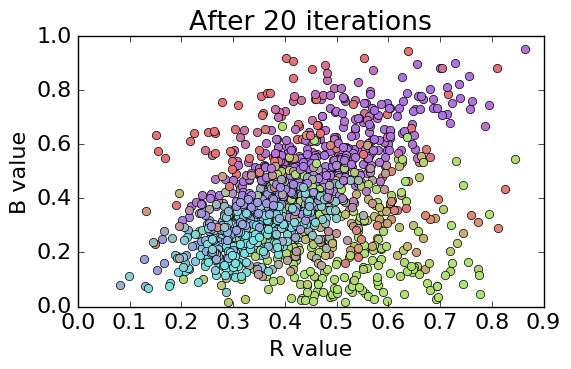

In [268]:
out = EM(img_data, init_means, init_covariances, init_weights, maxiter=20)
plot_responsibilities_in_RB(df, out['resp'], 'After 20 iterations')

##### Quiz Question: Calculate the likelihood (score) of the first image in our data set (images[0]) under each Gaussian component through a call to multivariate_normal.pdf. Given these values, what cluster assignment should we make for this image? Hint: don't forget to use the cluster weights.



In [284]:
for k in range(len(out['weights'])):
    print('Cluster', k , out['weights'][k] * multivariate_normal.pdf(np.array(df.ix[0,['red', 'green', 'blue']]), mean=out['means'][k], cov=out['covs'][k]))

Cluster 0 4.99435106017
Cluster 1 0.0849313882585
Cluster 2 2.22176824162
Cluster 3 72.2855769742


In [287]:
weights = out['weights']
means = out['means']
covariances = out['covs']
rgb = np.array(df.ix[:, ['red', 'green', 'blue']]) 
N = len(df) # number of images
K = len(means) # number of clusters

assignments = [0]*N
probs = [0]*N

for i in range(N):
    # Compute the score of data point i under each Gaussian component:
    p = np.zeros(K)
    for k in range(K):
        p[k] = weights[k]*multivariate_normal.pdf(rgb[i], mean=means[k], cov=covariances[k])
        
    # Compute assignments of each data point to a given cluster based on the above scores:
    assignments[i] = np.argmax(p)
    
    # For data point i, store the corresponding score under this cluster assignment:
    probs[i] = np.max(p)

assignments = pd.DataFrame({'assignments':assignments, 'probs':probs, 'image': df['pic']})

In [298]:
def get_top_images(assignments, cluster, k=5):
    # YOUR CODE HERE
    images_in_cluster = assignments[assignments.assignments == cluster]
    top_images = images_in_cluster.sort_values(by='probs', ascending=False)[:k]
    return top_images['image']

In [303]:
def display_images(images):
    from IPython.display import display
    
    for image in images:
        display(image)


Component 0


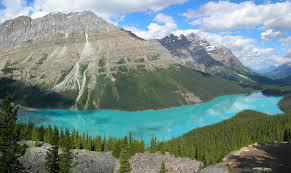

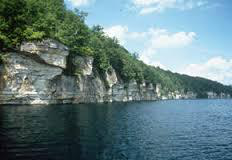

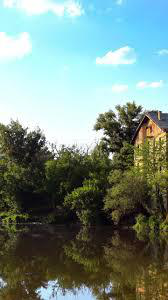

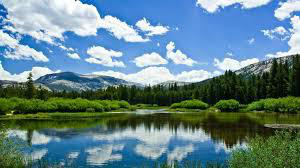

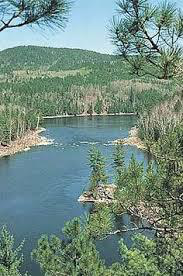



Component 1


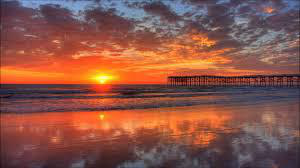

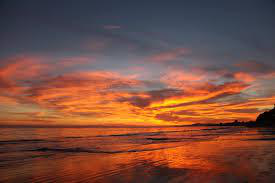

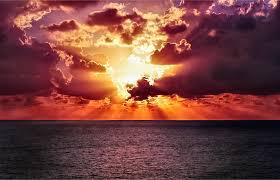

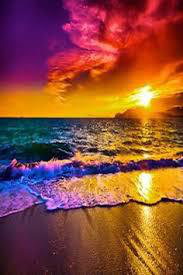

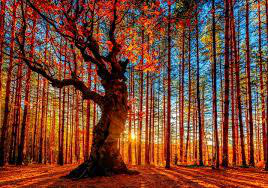



Component 2


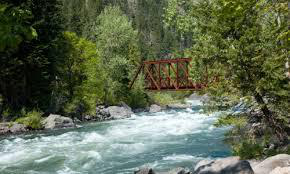

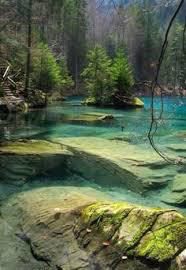

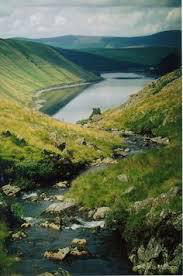

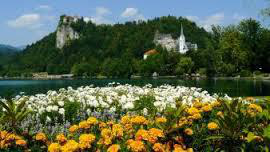

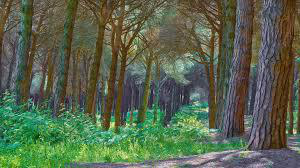



Component 3


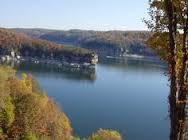

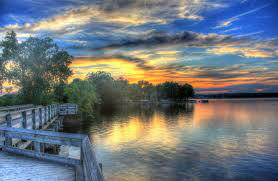

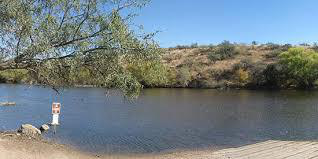

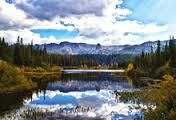

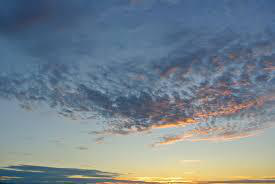

In [304]:
for component_id in range(4):
    print('Component {0:d}'.format(component_id))
    images = get_top_images(assignments, component_id)
    display_images(images)
    #save_images(images, 'component_{0:d}_%d.jpg'.format(component_id))
    print('\n')

##### Quiz Question: Which of the following images are not in the list of top 5 images in the first cluster?

